**Implemente una función que reciba una señal de múltiples canales y épocas y calcule la Energía de 
promedio de cada canal**

In [227]:
# Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io 
import glob
from scipy.stats import shapiro
from scipy.stats import levene  
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import adfuller
import math

In [113]:
# Abrir los archivos
rut_control = 'datos_senales_datos_parkinson_cursos/control/*.mat'
rut_parkins = 'datos_senales_datos_parkinson_cursos/parkinson/*.mat'

archivos_mat_control = glob.glob( rut_control )
archivos_mat_parkins = glob.glob( rut_parkins )

datos_control = []
datos_parkins = []

for archivo_c in archivos_mat_control:
    contenido_c = scipy.io.loadmat(archivo_c)
    datos_control.append( contenido_c )

for archivo_p in archivos_mat_parkins:
    contenido_p = scipy.io.loadmat(archivo_p)
    datos_parkins.append( contenido_p )

datos_control[2]['data'].shape                      # canales, muestras por epoca, epocas

(8, 2000, 146)

**Calculo de la energia promedio de cada canal**



In [195]:
def ePrommedioCanal(data):
    e_t = []

    for paciente in data:
        senal = paciente['data']

        e = np.sum( senal ** 2, axis= 2 )   #dimension (8, 2000) por epocas
        e_p = np.mean( e, axis= 1 )         #dimension (8)
        e_t.append( e_p )

    df = pd.DataFrame(e_t)
    df.columns = [f'canal {i+1}' for i in range(df.shape[1])] 
    df.index.name = 'Sujeto'
    
    return df

**Creacion del Dataframe Canal, sujeto**

In [196]:
control = ePrommedioCanal(datos_control)
parkinson = ePrommedioCanal(datos_parkins)

In [197]:
control.head()

,canal 1,canal 2,canal 3,canal 4,canal 5,canal 6,canal 7,canal 8
Sujeto,,,,,,,,
0,1931.908532,1888.731712,2048.413463,1665.507626,2675.714672,2271.974227,2050.319483,2219.273956
1,1405.043452,1550.367302,1830.834467,1729.587202,1467.750422,8262.676313,5883.899672,6660.291077
2,1032.853152,1334.731976,2098.745047,1041.763064,2101.483556,1070.283495,1163.631249,1423.492602
3,2630.691976,2601.293108,2890.631963,2639.313819,2674.957729,7941.560547,7962.975409,8382.795922
4,1554.909718,1658.033108,1756.590591,1833.573369,1961.567383,4459.229020,3149.661688,3617.636022


In [198]:
parkinson.head()

,canal 1,canal 2,canal 3,canal 4,canal 5,canal 6,canal 7,canal 8
Sujeto,,,,,,,,
0,889.334415,805.174070,773.603886,678.519589,864.510858,1630.072263,1694.594355,1830.833672
1,1241.700544,828.110526,847.757764,1020.227672,1177.031888,4414.858003,3706.366793,4581.851124
2,3314.012924,3791.058013,3652.259548,3629.230055,4046.695123,21893.497340,15603.053148,22825.422696
3,1816.287909,1688.355579,1877.334144,1668.001138,1728.466991,9816.041258,9859.969151,11689.145245
4,3400.216324,3626.457084,5122.036666,4179.538974,3958.652302,20097.403314,15592.205539,24731.860867


**Pruebas estadisticas**

In [ ]:
def analizar_normalidad_y_graficar(control, parkinson, alfa=0.05):
    # Asegurar que los datos sean numéricos
    for df in (control, parkinson):
        for col in df.columns:
            if "canal" in col.lower():
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # Obtener lista de canales (soporta "canal 1", "canal 2", etc.)
    canales = [col for col in control.columns if "canal" in col.lower()]

    # --- Prueba de normalidad ---
    for canal in canales:
        datos_control = control[canal].dropna()
        datos_parkinson = parkinson[canal].dropna()

        # Calcular Shapiro solo si hay suficientes datos
        if len(datos_control) > 2 and len(datos_parkinson) > 2:
            _, p_control = shapiro(datos_control)
            _, p_parkinson = shapiro(datos_parkinson)
        else:
            p_control, p_parkinson = np.nan, np.nan

        # Mostrar resultados
        print(f"\nCanal: {canal}")
        print(f"Shapiro-Wilk - Grupo 1: p-valor={p_control:.4f}" if not np.isnan(p_control) else "Shapiro-Wilk - Grupo 1: No suficientes datos")
        print("Normal" if p_control > alfa else "No normal" if not np.isnan(p_control) else "")
        print(f"Shapiro-Wilk - Grupo 2: p-valor={p_parkinson:.4f}" if not np.isnan(p_parkinson) else "Shapiro-Wilk - Grupo 2: No suficientes datos")
        print("Normal" if p_parkinson > alfa else "No normal" if not np.isnan(p_parkinson) else "")

    # --- Graficar histogramas para canal 1 y canal 2 ---
    canales_a_graficar = ["canal 1", "canal 2"]
    plt.figure(figsize=(12, 6))
 
    for i, canal in enumerate(canales_a_graficar, 1):
        if canal in control.columns:
            datos_control = control[canal].dropna()
            datos_parkinson = parkinson[canal].dropna()

            plt.subplot(1, 2, i)
            min_valor = min(datos_control.min(), datos_parkinson.min())
            max_valor = max(datos_control.max(), datos_parkinson.max())
            bins = np.linspace(min_valor, max_valor, 25)

            plt.hist(datos_control, bins=bins, alpha=0.7, color='purple', label='Control')
            plt.hist(datos_parkinson, bins=bins, alpha=0.7, color='blue', label='Parkinson')
            plt.title(f"Distribución {canal}")
            plt.xlabel("Amplitud (mV)")
            plt.ylabel("Frecuencia")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)
        else:
            plt.subplot(1, 2, i)
            plt.text(0.5, 0.5, f"{canal}\n(no hay datos)", ha='center', va='center')
            plt.axis('off')

    plt.tight_layout()
    plt.show()



Canal: canal 1
Shapiro-Wilk - Grupo 1: p-valor=0.0187
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0102
No normal

Canal: canal 2
Shapiro-Wilk - Grupo 1: p-valor=0.0175
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0042
No normal

Canal: canal 3
Shapiro-Wilk - Grupo 1: p-valor=0.0148
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0031
No normal

Canal: canal 4
Shapiro-Wilk - Grupo 1: p-valor=0.0008
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0005
No normal

Canal: canal 5
Shapiro-Wilk - Grupo 1: p-valor=0.0038
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0023
No normal

Canal: canal 6
Shapiro-Wilk - Grupo 1: p-valor=0.0000
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0000
No normal

Canal: canal 7
Shapiro-Wilk - Grupo 1: p-valor=0.0000
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0000
No normal

Canal: canal 8
Shapiro-Wilk - Grupo 1: p-valor=0.0000
No normal
Shapiro-Wilk - Grupo 2: p-valor=0.0000
No normal


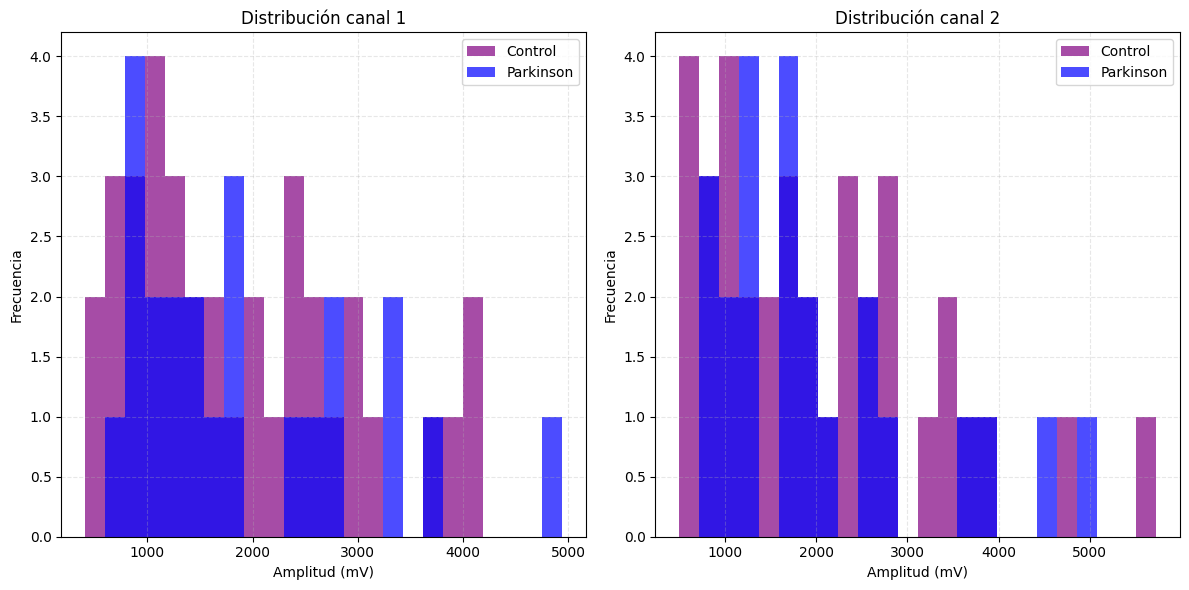

In [221]:
analizar_normalidad_y_graficar( control, parkinson )

In [236]:
def prueba_homocedasticidad_y_graficar(control, parkinson, alpha=0.05):
    # Detectar columnas que empiecen con "canal" sin importar mayúsculas
    canales = [c for c in control.columns if c.lower().startswith("canal")]

    if len(canales) == 0:
        print("⚠️ No se encontraron columnas que empiecen con 'canal'.")
        return

    # --- Prueba de homocedasticidad ---
    for canal in canales:
        _, p = levene(control[canal], parkinson[canal])
        resultado = "Homocedástico" if p > alpha else "No Homocedástico"
        print(f"Canal: {canal} - Levene p-valor={p:.4f} → {resultado}")

    # --- Gráficos de boxplots ---
    total = len(canales)
    columnas = 4  # número de gráficas por fila
    filas = math.ceil(total / columnas)

    fig, axes = plt.subplots(filas, columnas, figsize=(16, 4 * filas))
    axes = axes.flatten()

    for i, canal in enumerate(canales):
        axes[i].boxplot([control[canal].dropna(), parkinson[canal].dropna()])
        axes[i].set_xticks([1, 2])
        axes[i].set_xticklabels(["Control", "Parkinson"])
        axes[i].set_title(canal)
        axes[i].grid(True)

    # Eliminar subplots vacíos si sobran
    for j in range(len(canales), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Canal: canal 1 - Levene p-valor=0.9132 → Homocedástico
Canal: canal 2 - Levene p-valor=0.6417 → Homocedástico
Canal: canal 3 - Levene p-valor=0.6404 → Homocedástico
Canal: canal 4 - Levene p-valor=0.4720 → Homocedástico
Canal: canal 5 - Levene p-valor=0.6807 → Homocedástico
Canal: canal 6 - Levene p-valor=0.5090 → Homocedástico
Canal: canal 7 - Levene p-valor=0.6676 → Homocedástico
Canal: canal 8 - Levene p-valor=0.6409 → Homocedástico


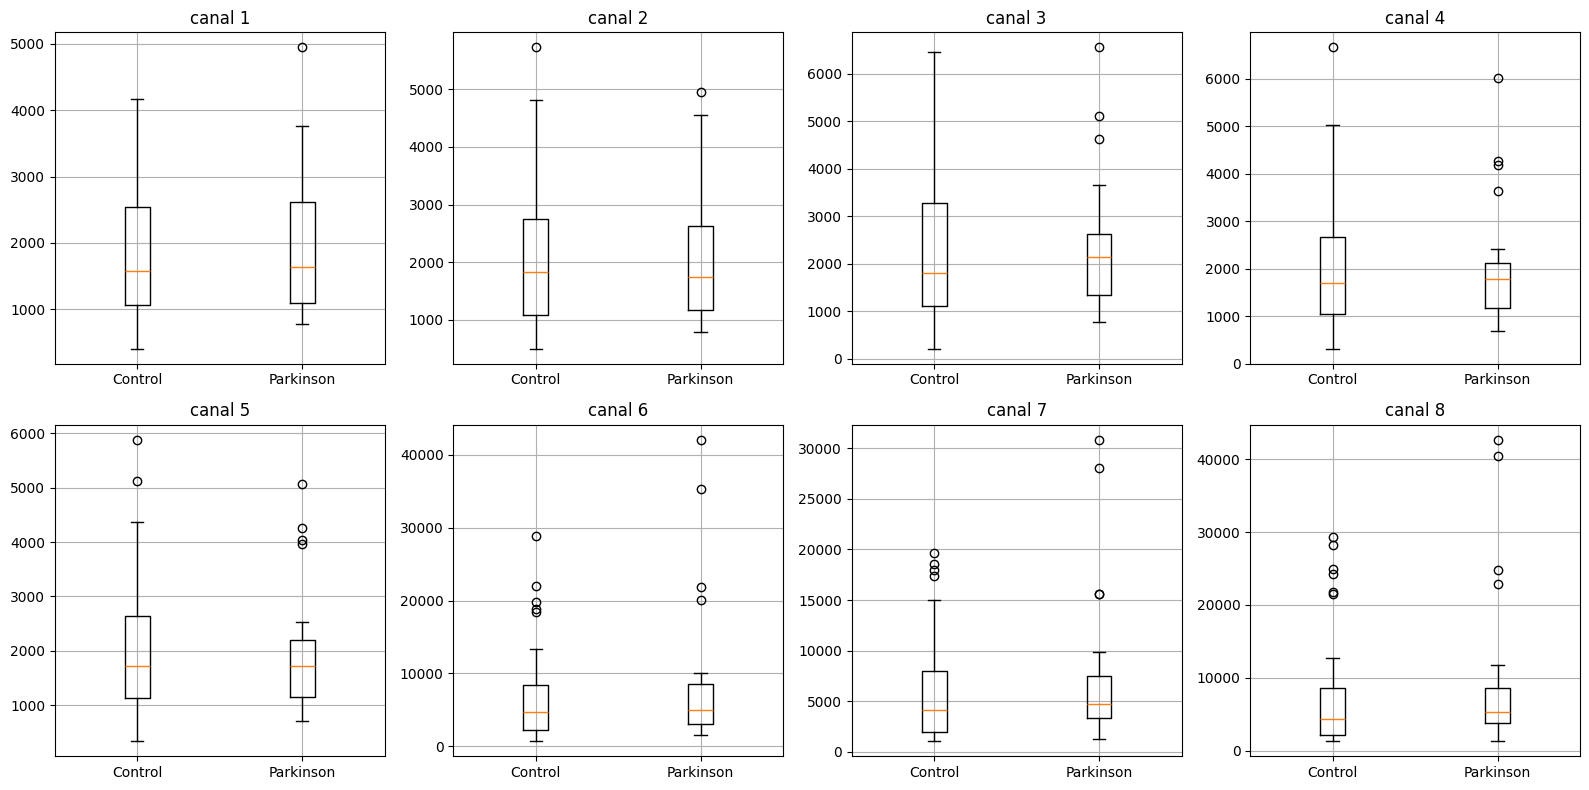

In [234]:
prueba_homocedasticidad_y_graficar(control, parkinson)

In [238]:
def prueba_mann_whitney(control, parkinson, alfa=0.05):
    canales = [c for c in control.columns if c.startswith("canal")]

    print("\nResultados del análisis Mann-Whitney U:")
    for canal in canales:
        grupo1 = control[canal].dropna()
        grupo2 = parkinson[canal].dropna()

        _, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        resultado = "Significativo" if p <= alfa else "No significativo"

        print(f"\nCanal: {canal}")
        print(f"p-valor: {p:.4f} ({resultado})")


In [237]:
prueba_mann_whitney(control, parkinson)


Resultados del análisis Mann-Whitney U:

Canal: canal 1
p-valor: 0.8581 (No significativo)

Canal: canal 2
p-valor: 0.9938 (No significativo)

Canal: canal 3
p-valor: 0.7149 (No significativo)

Canal: canal 4
p-valor: 0.6804 (No significativo)

Canal: canal 5
p-valor: 0.9442 (No significativo)

Canal: canal 6
p-valor: 0.4795 (No significativo)

Canal: canal 7
p-valor: 0.2941 (No significativo)

Canal: canal 8
p-valor: 0.3087 (No significativo)
